<a href="https://colab.research.google.com/github/vyankateshgithubber/Audio-Source-Count-Estimation/blob/working/PerSecondCountFullSTFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries 
import librosa
import numpy as np
import matplotlib.pyplot as plt
!pip install wavefile
import wavefile
import wave, os, glob
from matplotlib.pyplot import figure
import math
from scipy.io.wavfile import write
!pip install noisereduce
from scipy.io import wavfile
import noisereduce as nr

In [ ]:
## Short Time Fourier Transform function, OUR ORIGINAL
def stft(y,sr):
  S = np.abs(librosa.stft(y,n_fft=512,hop_length=256))
  return S

In [ ]:
####code that will give the offset value for 1s audio file which has the maximum energy, no framing and windowing was done . 
# directly 16K samples for 1s are taken and the energy is caluculated and they are ranked accordingly.
def GiveMeOffset(filename):
  signal, sr = librosa.load(filename,sr=16000)
  requiredOffset=0
  Max=0
  count=0
  for i in range(0,sr*5,sr):
    frameOfOneSecond=signal[i:i+16000]
    energy = np.array(sum(abs(frameOfOneSecond**2)))
    #print(energy)
    if energy>Max:
      requiredOffset=i//sr
      Max=energy
  return requiredOffset

In [ ]:
## Mix Libricount and custom dataset
def features_labels(sr=16000,offset=0,duration=1):
  X = []
  y = []

  path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_165/'

  for k1 in np.arange(0.02,1.02,0.02):
    for k2 in np.arange(0.02,1.02,0.02):
      audiofilepath = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
      offset = GiveMeOffset(audiofilepath)
      signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
      X.append(stft(signal,sr))
      y.append(2)

  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)


  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path +'1_'+str(round(0,3))+'_'+str(round(k1,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)

  
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/New folder'
  for filename in glob.glob(os.path.join(path, '2'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(2)


  for filename in glob.glob(os.path.join(path, '1'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)
  
  #add the code so as to take the audio file and append the x and y lablel for the 0 source,
  #source 0-0 , source 1-1 and source 2-2 (sources,labels)
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/0'
  for filename in glob.glob(os.path.join(path, '*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(0)


  X = np.array(X)
  y = np.array(y)
  size = X.shape
  #print('X : ',size)
  X = X.reshape((size[0],size[1],size[2],1))
  y = y.reshape((size[0],1))
  return X,y

In [ ]:
X,y = features_labels()
X.shape,y.shape

((6060, 257, 63, 1), (6060, 1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
print(X_train.shape,y_train.shape)

(4848, 257, 63, 1) (4848, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

def model1():
  input_shape = X_train.shape[1:]
  
  model = models.Sequential([
      layers.Input(shape=input_shape),
      preprocessing.Resizing(32, 32), 
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(3),#changed parameter from 1 to 3
    ])
  
  model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

  history = model.fit(X_train, y_train,validation_split=0.2, epochs=10)
  
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print("Test Loss ", test_loss)
  print("Test Accuracy ", test_acc)
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return model

Epoch 1/10
122/122 [==============================] - 14s 109ms/step - loss: 0.5572 - accuracy: 0.7287 - val_loss: 0.3317 - val_accuracy: 0.8546
Epoch 2/10
122/122 [==============================] - 13s 107ms/step - loss: 0.3356 - accuracy: 0.8577 - val_loss: 0.2297 - val_accuracy: 0.9227
Epoch 3/10
122/122 [==============================] - 13s 107ms/step - loss: 0.2469 - accuracy: 0.8989 - val_loss: 0.2151 - val_accuracy: 0.8897
Epoch 4/10
122/122 [==============================] - 13s 107ms/step - loss: 0.1842 - accuracy: 0.9283 - val_loss: 0.1731 - val_accuracy: 0.9216
Epoch 5/10
122/122 [==============================] - 13s 107ms/step - loss: 0.1455 - accuracy: 0.9456 - val_loss: 0.1637 - val_accuracy: 0.9351
Epoch 6/10
122/122 [==============================] - 13s 107ms/step - loss: 0.1272 - accuracy: 0.9538 - val_loss: 0.1491 - val_accuracy: 0.9381
Epoch 7/10
122/122 [==============================] - 13s 107ms/step - loss: 0.1020 - accuracy: 0.9629 - val_loss: 0.1442 - val_ac

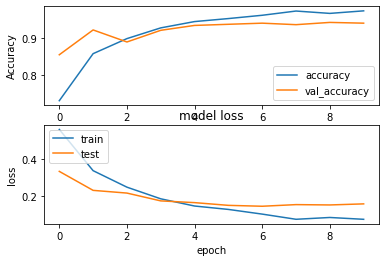

In [ ]:
model = model1()

In [ ]:
model.save('/content/drive/MyDrive/MajorProject/Models/FullSTFT.h5')

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MajorProject/Models/FullSTFT.h5')
# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [ ]:
y_test_predict = new_model.predict(X_test)
y_pred = []
for y_p in y_test_predict:
  y_pred.append(np.argmax([y_p]))
y_pred = np.array(y_pred).reshape((len(y_pred),1))

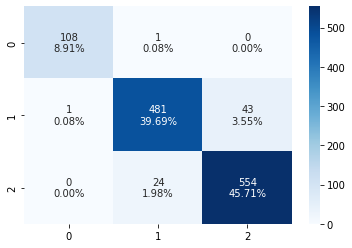

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test , y_pred)
#sns.heatmap(cf_matrix, annot=True)

#group_names = ["1","2","False Neg","True Pos"]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
def prediction(test_filepath,offset=0,duration=1):
  signal, sr = librosa.load(test_filepath,sr=16000,duration=duration,offset=offset) ## offset 
  signal = nr.reduce_noise(y=signal, sr=sr)
  wavfile.write("filtered.wav", sr, signal)
  feature = stft(signal,sr)
  size = feature.shape
  feature = feature.reshape(1,size[0],size[1])
  output = new_model.predict(feature)
  output = np.argmax(output)
  return output

In [ ]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
import numpy as np
import librosa
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plotCounts(test_filepath,output):
      samplingFrequency, signalData = wavfile.read(test_filepath)

      plot.figure(figsize=(15,12))
      plot.subplot(211)
      plot.title('Audio Signal')
      duration = len(signalData)/samplingFrequency
      time = np.arange(0,duration,1/samplingFrequency)

      for i in range(0,5):
        if output[i]==0:
          plot.axvspan(i, i+1, color='plum', alpha=0.5, lw=0,label='count=0')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='violet')
        elif output[i]==1:
          plot.axvspan(i, i+1, color='turquoise', alpha=0.5, lw=0,label='count=1')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='darkturquoise')
        else :
          plot.axvspan(i, i+1, color='palegreen', alpha=0.5, lw=0,label='count=2')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='green')
          

      Count_0 = mpatches.Patch(color='plum', label='Count=0')
      Count_1 = mpatches.Patch(color='turquoise', label='Count=1')
      Count_2 = mpatches.Patch(color='palegreen', label='Count=2')
      plt.legend(handles=[Count_0, Count_1,Count_2],loc=1,prop={'size': 16})

      plot.xlabel('Time(s)')
      plot.ylabel('Amplitude')

      plot.figure(figsize=(19,13))
      plot.subplot(212)
      plot.specgram(signalData,Fs=samplingFrequency)
      plot.title('Spectrogram')
      plot.colorbar()
      plot.xlabel('Time')
      plot.ylabel('Frequency')
      plot.show()

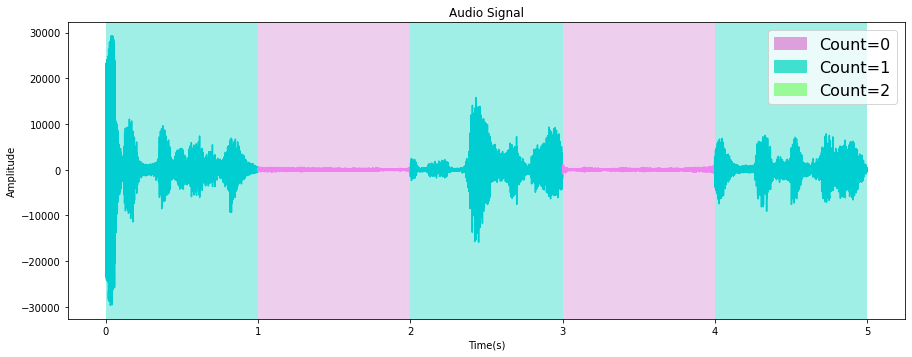

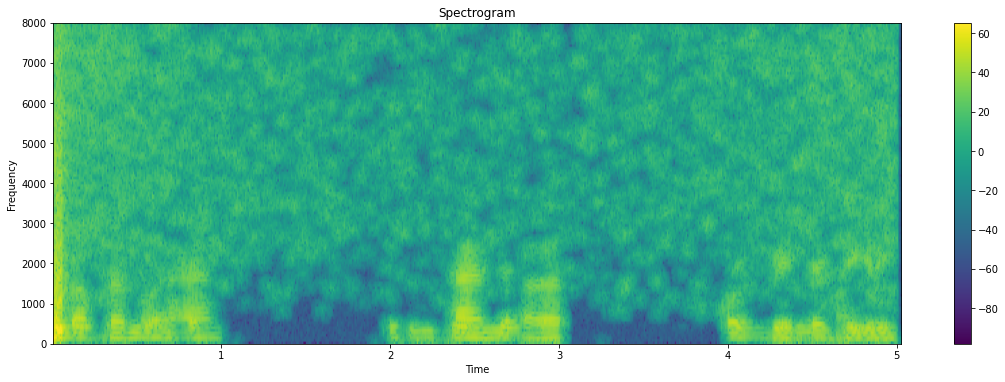

In [ ]:
path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_135/'
k1 = 0.5
k2 = 0.2
TwoSource = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
SingleSource = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
#SingleSource='/content/drive/MyDrive/MajorProject/s1_female.wav'
NoSource='/content/drive/MyDrive/MajorProject/AudioDataset/0/0_0216c2.wav'

test_filepath ='/content/mywav_reduced_noise.wav'
output = []
for i in range(5):
  output.append(prediction(test_filepath,i,1))
plotCounts(test_filepath,output)

In [ ]:
import IPython.display as ipd
ipd.Audio(test_filepath) 

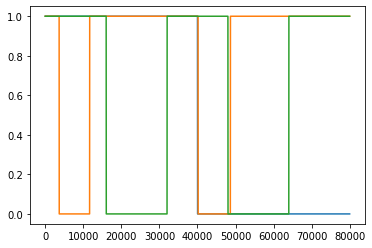

In [ ]:
in1 = [[0, 40000]]
in2 = [[0, 3637], [11644, 40153], [48641, 80000]]
in3= [[0,16000],[16000,32000],[32000,48000],[48000,64000],[64000,80000]]
p1 = [0]*80000
p2 = [0]*80000
p3 = [0]*80000

for r in in1:
  for i in range(r[0],r[1]):
    p1[i]=1

for r in in2:
  for i in range(r[0],r[1]):
    p2[i]=1


c = 1
for r in in3:
  for i in range(r[0],r[1]):
    p3[i]=c
  if(c==1):
    c=0
  else:
    c=1

plt.plot(p1)
plt.plot(p2)
plt.plot(p3)

In [ ]:
# LibriCount Dataset 
def features_labels(sr=16000,offset=0,duration=1):
  X = []
  y = []

  
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/New folder'
  for filename in glob.glob(os.path.join(path, '2'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(2)


  for filename in glob.glob(os.path.join(path, '1'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)
  
  #add the code so as to take the audio file and append the x and y lablel for the 0 source,
  #source 0-0 , source 1-1 and source 2-2 (sources,labels)
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/0'
  for filename in glob.glob(os.path.join(path, '*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(0)


  X = np.array(X)
  y = np.array(y)
  size = X.shape
  X = X.reshape((size[0],size[1],size[2],1))
  y = y.reshape((size[0],1))
  return X,y

In [ ]:
# Only custom dataset function 
def features_labels(sr=16000,offset=0,duration=1):
  X = []
  y = []
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_165/'

  for k1 in np.arange(0.02,1.02,0.02):
    for k2 in np.arange(0.02,1.02,0.02):
      audiofilepath = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
      offset = GiveMeOffset(audiofilepath)
      signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
      X.append(stft(signal,sr))
      y.append(2)

  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)


  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path +'1_'+str(round(0,3))+'_'+str(round(k1,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)
  
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/0'
  for filename in glob.glob(os.path.join(path, '*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(0)

  X = np.array(X)
  y = np.array(y)
  size = X.shape
  X = X.reshape((size[0],size[1],size[2],1))
  y = y.reshape((size[0],1))
  return X,y

In [ ]:

# load data
rate, data = wavfile.read("/content/Source_1.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("mywav_reduced_noise.wav", rate, reduced_noise)